In [ ]:
#Import thư viện cần thiết
import sys
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors

from typing import List, Tuple, Union
from pyspark.rdd import RDD
from math import sqrt
import math

from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, lit, when
from pyspark.sql.functions import explode
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import plotly.express as px
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import metrics

In [ ]:
# Tạo một SparkSession
spark = SparkSession.builder \
    .appName("DHC") \
    .getOrCreate()


## **1. Clustering**

In [ ]:
filename = "/content/pca_data.csv"

#Đọc dữ liệu
data = spark.read.csv(filename, header=False, inferSchema=True)
dataRDD = data.rdd.map(lambda row: Vectors.dense([row[0], row[1], row[2]]))

In [ ]:
dataRDD.cache() # Lưu RDD vào bộ nhớ để tái sử dụng sau

PythonRDD[15] at RDD at PythonRDD.scala:53

In [ ]:
dataRDD.count()

4935

In [ ]:
dataRDD.take(5)

[DenseVector([0.5139, -1.8689, 1.2104]),
 DenseVector([-0.6302, -4.1878, 0.4854]),
 DenseVector([-0.5929, -0.3955, -0.957]),
 DenseVector([-0.5705, -0.0701, 1.0893]),
 DenseVector([-3.8157, -0.81, 3.3359])]

**Thực hiện thuật toán DHC**




In [ ]:
def variance(data):
    count = data.count()
    # Tính giá trị trung bình
    mean = data.reduce(lambda x, y: x + y) / count
    # Tính phương sai
    var = data.map(lambda x: (x - mean) ** 2).reduce(lambda x, y: x + y) / count
    return var

In [ ]:
def variance_based_split(rdd):
    len_feature = len(rdd.first())
    # Tính phương sai của các thuộc tính bằng hàm variance
    variances = [variance(rdd.map(lambda x: x[i])) for i in range(len_feature)]
    # Xác định thuộc tính với phương sai lớn nhất
    max_variance = variances.index(max(variances))

    # Sort data dựa trên thuộc tinh có phương sai lớn nhất
    sort_rdd = rdd.sortBy(lambda x: x[max_variance]).zipWithIndex().map(lambda x: (x[1], x[0]))
    count = sort_rdd.count()

    # Ktra count
    if count == 0:
        return rdd, spark.sparkContext.emptyRDD()

   # Thực hiện tính điểm trung vị
    median_index = count // 2
    median_value = sort_rdd.lookup(median_index)[0][max_variance]

    # Chia dữ liệu làm 2 dựa trên điểm trung vị
    cluster1 = rdd.filter(lambda x: x[max_variance] <= median_value)
    cluster2 = rdd.filter(lambda x: x[max_variance] > median_value)

    return cluster1, cluster2

In [ ]:
def divisive_clustering(rdd, max_clusters):
    # Lưu dữ liệu vào một bộ dữ liệu (RDD, label của điểm)
    clusters = [(rdd, 0)]
    # Biến đếm cụm
    cluster_counter = 1
    # Vòng lặp xác định kích thước cụm có bé hơn k cụm
    while len(clusters) < max_clusters:
        # Tạo cụm mới
        new_clusters = []
        # Vòng lặp qua các cụm và nhãn trong clusters
        for cluster, label in clusters:
            # Thực hiện chia dữ liệu nếu kích thược dữ liệu lớn hơn 1
            if cluster.count() > 1:
                # Chia dữ liệu bằng hàm variance_based_split
                c1, c2 = variance_based_split(cluster)
                # Thực hiện thêm vào cụm mới các cụm đã chia
                new_clusters.append((c1, label))
                new_clusters.append((c2, cluster_counter))
                # Tăng biến đếm thêm 1
                cluster_counter += 1
            else:
                # Thực hiện thêm vào cụm mới (cluster, label)
                new_clusters.append((cluster, label))
        # Gán cho biến clusters = new_clusters
        clusters = new_clusters
    return clusters

In [ ]:
k = 4
dhc = divisive_clustering(dataRDD, k)

In [ ]:
for i, cluster in enumerate(dhc):
  cluster_rdd, label = cluster
  print(f"Cluster {label} (label: {label}) has {cluster_rdd.count()} points")

Cluster 0 (label: 0) has 1235 points
Cluster 2 (label: 2) has 1233 points
Cluster 1 (label: 1) has 1234 points
Cluster 3 (label: 3) has 1233 points


In [ ]:
cluster_data = []
for i, cluster_tuple in enumerate(dhc):
    cluster_rdd, label = cluster_tuple
    cluster_data.extend([(row.tolist(), label) for row in cluster_rdd.collect()])

In [ ]:
print(len(cluster_data))

4935


In [ ]:
cluster_df = spark.createDataFrame(cluster_data, ["features", "cluster"])
num_features = len(cluster_data[0][0])
df = cluster_df.select([col("features")[i].alias(f"col{i + 1}") for i in range(num_features)] + ["cluster"])

In [ ]:
print(cluster_df.count())

4935


In [ ]:
cluster_df.show()

+--------------------+-------+
|            features|cluster|
+--------------------+-------+
|[-0.6302173578035...|      0|
|[-0.5928806163868...|      0|
|[-0.5705047630525...|      0|
|[-3.8156515579030...|      0|
|[-1.5232001897664...|      0|
|[-1.7430138718627...|      0|
|[-1.7323340901415...|      0|
|[-0.2698808918304...|      0|
|[0.02535843742586...|      0|
|[-0.7643872586627...|      0|
|[-2.3052508810681...|      0|
|[0.13717539973822...|      0|
|[-1.0247102023315...|      0|
|[-0.0688803047339...|      0|
|[-2.9323325404993...|      0|
|[-1.4726271542149...|      0|
|[-1.2306708595110...|      0|
|[-2.2984464304775...|      0|
|[-0.6963388666078...|      0|
|[0.04323784662355...|      0|
+--------------------+-------+
only showing top 20 rows



In [ ]:
ds_download = cluster_df.toPandas()
ds_download.to_csv('cluster_dhc.csv', header = True)

In [ ]:
numeric = spark.read.csv("/content/data_fixed_numeric.csv", header=True, inferSchema=True)
# numeric = spark.read.csv("/home/kanh/Desktop/Project/data_fixed_numeric.csv", header=True, inferSchema=True)
print(numeric.count())

4935


In [ ]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
#Thêm cột index liên tiếp vào numeric va df
line = cluster_df.withColumn("index", row_number().over(Window.orderBy(lit(1))))
numeric = numeric.withColumn("index", row_number().over(Window.orderBy(lit(1))))

In [ ]:
print(line.count())
print(numeric.count())

4935
4935


In [ ]:
# Thực hiện join hai DataFrames dựa trên cột "index"
result_df = numeric.join(line, on="index").drop("index")

# Hiển thị kết quả
result_df.show()

+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+--------------+------+---------------+--------------+---------------+-------------+--------------------+-------+
|Customer_Age|Dependent_count|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Attrition_Flag|Gender|Education_Level|Marital_Status|Income_Category|Card_Category|            features|cluster|
+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+

In [ ]:
print(result_df.count())

4935


In [ ]:
ds_download = result_df.toPandas()
ds_download.to_csv('divisive_dhc.csv', header = True)


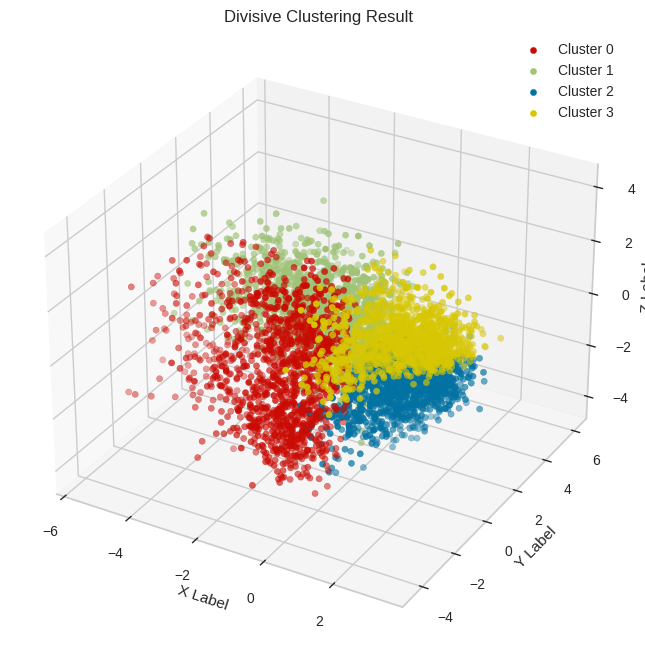

In [ ]:
# Plot the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, cluster_tuple in enumerate(dhc):
    cluster_rdd, label = cluster_tuple
    cluster_data = cluster_rdd.collect()
    cluster_data = [[row[0], row[1], row[2]] for row in cluster_data]
    cluster_data = list(zip(*cluster_data))
    ax.scatter(cluster_data[0], cluster_data[1], cluster_data[2], c=colors[i % len(colors)], label=f"Cluster {i}")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('Divisive Clustering Result')
plt.legend()
plt.show()

In [ ]:
from itertools import combinations
import numpy as np
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

In [ ]:
def distance(x, y):
    return sum([(a - b) ** 2 for a, b in zip(x, y)]) ** 0.5

def calinski_harabasz_index(rdd_v, cluster_v):
    # Collect all points and their labels on the driver
    points_with_labels = []
    for rdd, label in zip(rdd_v, cluster_v):
        points_with_labels.extend([(point, label) for point in rdd.collect()])

    n = len(points_with_labels)
    k = len(rdd_v)

    # Compute the overall mean of all points
    overall_sum = np.sum([np.array(point) for point, _ in points_with_labels], axis=0)
    overall_mean = overall_sum / n

    def cluster_dispersion(cluster_points):
        if len(cluster_points) == 0:
            return 0.0
        cluster_mean = np.mean([np.array(p) for p in cluster_points], axis=0)
        w_k = sum([np.sum((np.array(p) - cluster_mean) ** 2) for p in cluster_points])
        return w_k

    w_k = sum([cluster_dispersion([p for p, l in points_with_labels if l == label]) for label in set(cluster_v)])

    b_k = sum([
        len([p for p, l in points_with_labels if l == label]) * np.sum((overall_mean - np.mean([np.array(p) for p, l in points_with_labels if l == label], axis=0)) ** 2)
        for label in set(cluster_v)
    ])

    ch_index = (b_k / (k - 1)) / (w_k / (n - k))
    return ch_index

def silhouette_coefficient(rdd_v, cluster_v):
    # Collect all points and their labels on the driver
    points_with_labels = []
    for rdd, label in zip(rdd_v, cluster_v):
        points_with_labels.extend([(point, label) for point in rdd.collect()])

    # Broadcast the points and labels mapping
    cluster_labels = sc.broadcast({point: label for point, label in points_with_labels})

    def compute_silhouette(point):
        point_cluster = cluster_labels.value[point]
        same_cluster_points = [p for p, l in points_with_labels if l == point_cluster]
        a = sum([distance(point, p) for p in same_cluster_points]) / len(same_cluster_points)

        b = float('inf')
        for other_cluster in set(cluster_v):
            if other_cluster != point_cluster:
                other_cluster_points = [p for p, l in points_with_labels if l == other_cluster]
                b = min(b, sum([distance(point, p) for p in other_cluster_points]) / len(other_cluster_points))

        return (b - a) / max(a, b)

    silhouette_scores = [compute_silhouette(point) for point, _ in points_with_labels]
    return sum(silhouette_scores) / len(silhouette_scores)


In [ ]:
# Extract RDDs and cluster labels into separate lists
rdd_dhc = [cluster[0] for cluster in dhc]
cluster_dhc = [cluster[1] for cluster in dhc]

In [ ]:
silhouette_score_DHC = silhouette_coefficient(rdd_dhc, cluster_dhc)
ch_index_DHC = calinski_harabasz_index(rdd_dhc, cluster_dhc)

In [ ]:
print("Silhouette Coefficient :", silhouette_score_DHC)
print("Calinski-Harabasz Index:", ch_index_DHC)

Silhouette Coefficient : 0.2251481035332149
Calinski-Harabasz Index: 1821.4155161315641


In [ ]:
spark.stop()

## **2. Visualization**

In [ ]:
visualDHC = pd.read_csv("/content/divisive_dhc.csv")

In [ ]:
visualDHC.head(5)

,Unnamed: 0,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,features,cluster
0,0,57,2,48,5,2,2,2436.0,680,1756.0,...,0.611,0.279,0,0,0,0,0,0,"[-0.630217357803575, -4.187782637646889, 0.485...",0
1,1,62,0,49,2,3,3,1438.3,0,1438.3,...,0.600,0.000,1,0,0,0,0,0,"[-0.5928806163868663, -0.39554035113777947, -0...",0
2,2,41,3,28,6,1,2,7768.0,1669,6099.0,...,0.833,0.215,0,0,0,1,0,0,"[-0.5705047630525357, -0.0700904321571848, 1.0...",0
3,3,47,4,42,6,0,0,4785.0,1362,3423.0,...,0.900,0.285,0,1,1,0,1,0,"[-3.8156515579030432, -0.8099879984435883, 3.3...",0
4,4,58,0,49,6,2,2,12555.0,1696,10859.0,...,0.714,0.135,0,1,0,0,3,0,"[-1.5232001897664005, -0.8680097172608067, 1.5...",0


In [ ]:
visualDHC.describe()

,Unnamed: 0,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,cluster
count,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,...,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000
mean,2467.000000,46.373252,2.377508,36.032624,3.952989,2.363323,2.443972,4805.276555,1139.260993,3666.015562,...,62.063019,0.685317,0.330433,0.166971,0.419048,1.422898,0.575481,1.036272,0.022492,1.499291
std,1424.756119,7.640569,1.272364,7.251151,1.496184,0.994672,1.101300,3668.132807,814.310093,3675.382651,...,19.697651,0.180909,0.286881,0.372987,0.493453,1.488124,0.636613,1.219729,0.165108,1.118238
min,0.000000,26.000000,0.000000,18.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,10.000000,...,10.000000,0.207000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1233.500000,41.000000,1.000000,32.000000,3.000000,2.000000,2.000000,2208.500000,0.000000,984.000000,...,44.000000,0.568000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2467.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,3214.000000,1247.000000,2015.000000,...,66.000000,0.684000,0.276000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,3700.500000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,6333.500000,1753.000000,5179.000000,...,78.000000,0.804000,0.582500,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,2.000000
max,4934.000000,68.000000,5.000000,53.000000,6.000000,6.000000,6.000000,17890.000000,2517.000000,15628.000000,...,113.000000,1.176000,0.995000,1.000000,1.000000,5.000000,2.000000,4.000000,2.000000,3.000000


<ipython-input-108-239967c680ad>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=visualDHC,x='cluster',palette=palette)


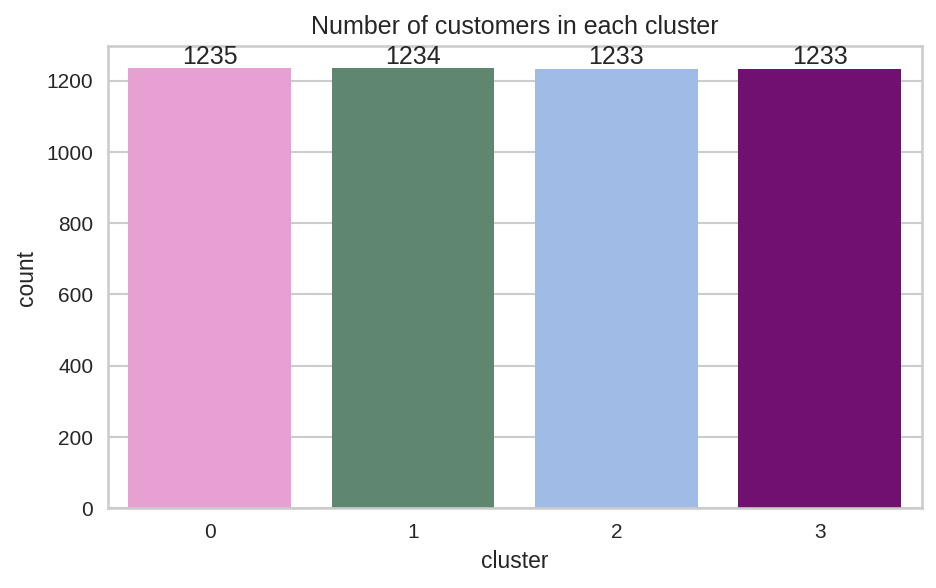

In [ ]:
plt.figure(figsize=(7,4),dpi=150)
cluster_colors = {0:"#f294d6",1:"#588c6e",2: "#94b8f2", 3: "#800080"}
palette = [cluster_colors[int(cluster)] for cluster in sorted(visualDHC['cluster'].unique())]
a = sns.countplot(data=visualDHC,x='cluster',palette=palette)
for i in a.containers: a.bar_label(i,)
plt.title('Number of customers in each cluster');

Các Cluster được phân chia với số lượng đồng đều nhau, chỉ chênh lệch 1-2 về số lượng

In [ ]:
visualDHC["cluster"] = visualDHC["cluster"].astype(str)
fig = px.scatter(visualDHC.sort_values(by='cluster'), x="Credit_Limit", y="Total_Trans_Amt",
                color='cluster', color_discrete_sequence=cluster_colors, opacity=0.8, symbol='cluster')
fig.update_yaxes(title_text="Total Transaction Amount")
fig.update_xaxes(title_text="Credit Limit")
fig.update_traces(showlegend=True)
fig.update_layout(title="Cluster's Profile Based On Credit Limit and Total Transaction Amount")
fig.show()

- **Cluster 0** (màu hồng):
  - Phân bố chủ yếu ở góc dưới bên trái và dải dưới của biểu đồ
  - Khách hàng chủ yếu giá trị các giao dịch thấp trong khoảng 1K-2.5K, hạn mức tín dụng của khách hàng trong khoảng từ 1.5K đến 4K và rải rát giảm dần khi tăng lên
- **Cluster 1** (màu xanh lá):
  - Phân bố ở khu vực giữa biểu đồ phía bên trái
  - Các khách hàng có khối lượng giao dịch ở mức trung bình khoảng 4K-5K với hạn mức tín dụng thẻ chủ yếu ở từ 1.5K dến 4K
- **Cluster 2** (màu xanh dương):
  - Nằm ở dải dưới của biểu đồ nhưng phân bố thưa hơn so cái các cluster khác
  - Là các khách hàng có tổng lượn giao dịch từ 1K-5K, hạn mức chủ yếu từ 1438 USD trở lên
- **Cluster 3** (màu tím)
  - Tập trung nhiều ở giữa biểu đồ góc bên trái, và 1 dải ở phía trên.
  - Là các khách hàng có khối lượng giao dịch từ 4K-5K, một số nhỏ từ 7K-9K, hạn mức chủ yếu của các khách hàng từ 1.4K-dưới 4K USD

In [ ]:
fig = px.box(visualDHC.sort_values(by='cluster'), x="cluster", y="Customer_Age", color='cluster', color_discrete_sequence=cluster_colors, points='all')
fig.update_yaxes(title_text="Customer's Age")
fig.update_xaxes(title_text="Clusters")
fig.update_layout(title = "Boxplots of Clusters based on Customer's Age")
fig.show()

- **Cluster 0** (màu hồng):
  - Mức trung vị tuổi là 46 và phạm vi tuổi khá rộng (26-68) nhóm khách hàng chủ yếu là người trung niên
- **Cluster 1** (màu xanh lá):
  - Mức trung vị tuổi bằng với Cụm 0 và khoảng tuổi nhỏ hơn cho thấy độ biến động về tuổi của khách hàng ít hơn, tức là khách hàng trong cụm này có độ tuổi khá đồng đều, và trẻ hơn so với Cụm 0.
- **Cluster 2** (màu xanh dương):
  - Cụm này có biểu đồ gần tương đương với Cụm 1 nhưng độ tuổi trung vị là 47 tuổi
- **Cluster 3** (màu tím)
  - Cũng tương tự với 2 cụm trên, độ tuổi trung vị của là 46, khoảng tuổi cũng tương đương so với các cụm khác </br>
Kết luận: Thuật toán đã đánh giá phân cụm độ tuổi chưa thực sự rõ, tuổi trong các cụm vẫn tương đương nhau, riêng cụm 0 có sự khác biệt hơn so với các cụm còn lại

In [ ]:
fig = px.box(visualDHC.sort_values(by='cluster'), x="cluster", y="Total_Trans_Ct", color='cluster', color_discrete_sequence=cluster_colors, points='all')
fig.update_yaxes(title_text="Total Transaction Count")
fig.update_xaxes(title_text="Clusters")
fig.update_layout(title = "Boxplots of Clusters based on Customer's Total Transaction Count")
fig.show()

- **Cluster 0** (màu hồng):
  - Số lượng giao dịch đa số nằm trong khoảng (10-86) và trung vị là 39 cho thấy cụm này có số lượng giao dịch thấp
  - Cụm này không có nhiều giá trị ngoại lai, riêng nhận thấy có khách hàng có số lượng giao dịch cao vượt trội so với các khách hàng khác (hơn 100)
- **Cluster 1** (màu xanh lá):
  - Số lượng giao dịch trong khoảng 31-101, giá trị trung vị là 73. Đây là cụm có số lượng giao dịch cao nhìn trong bộ dữ liệu
- **Cluster 2** (màu xanh dương):
  - Số lượng giao dịch cụm này khá cao (22-99) và rất ít giá trị ngoại lai
- **Cluster 3** (màu tím):
  - Đây là cụm có số lượng giao dịch cao nhất trong 4 cụm với giá trị cận trên lên đến 113. Nhưng cụm này vẫn có nhiều giá trị ngoại lai phân bố dày.

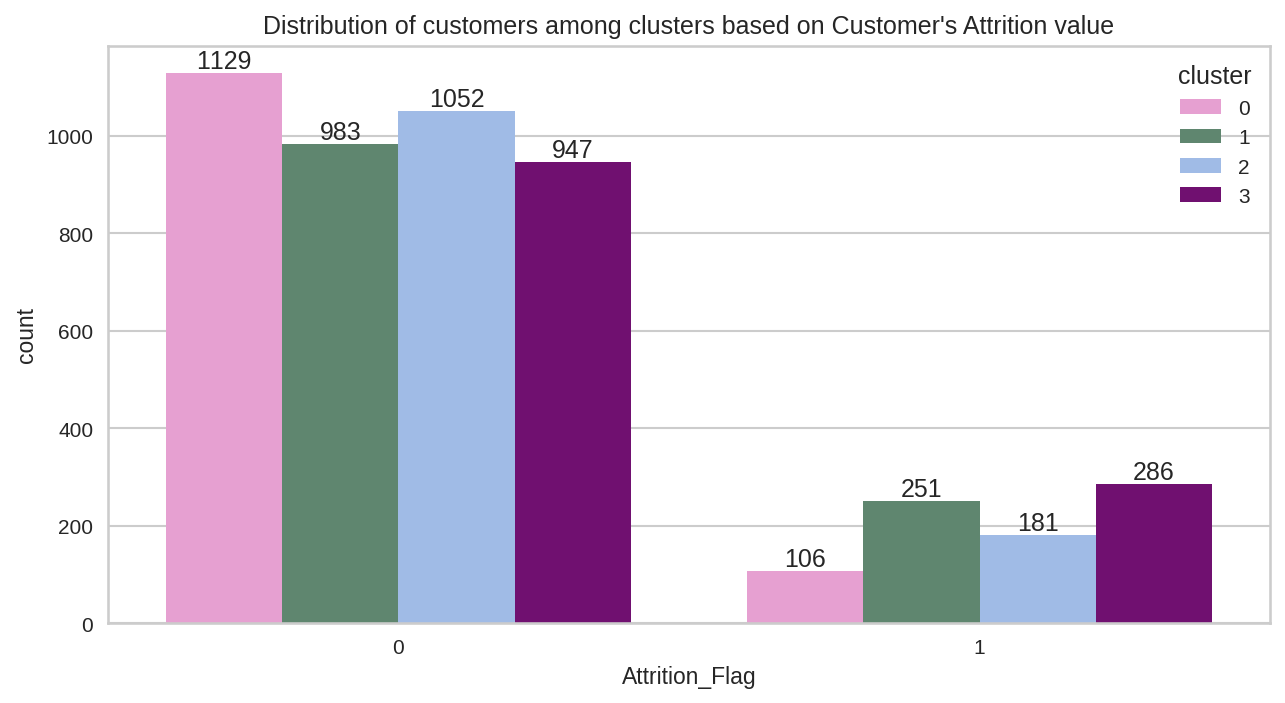

In [ ]:
plt.figure(figsize=(10,5),dpi= 150)
palette = [cluster_colors[int(cluster)] for cluster in sorted(visualDHC['cluster'].unique())]
a = sns.countplot(data=visualDHC.sort_values(by='cluster'),x='Attrition_Flag',hue='cluster',palette=palette)
for i in a.containers: a.bar_label(i,)
plt.title ("Distribution of customers among clusters based on Customer's Attrition value");

Số lượng khách hàng trong 4 cụm là tương đương nhau, theo biểu đồ cho thấy số lượng khách hàng đã rời bỏ của cụm 0 là thấp nhất (Attrition_Flag = 1), và cụm 4 là cao nhất.

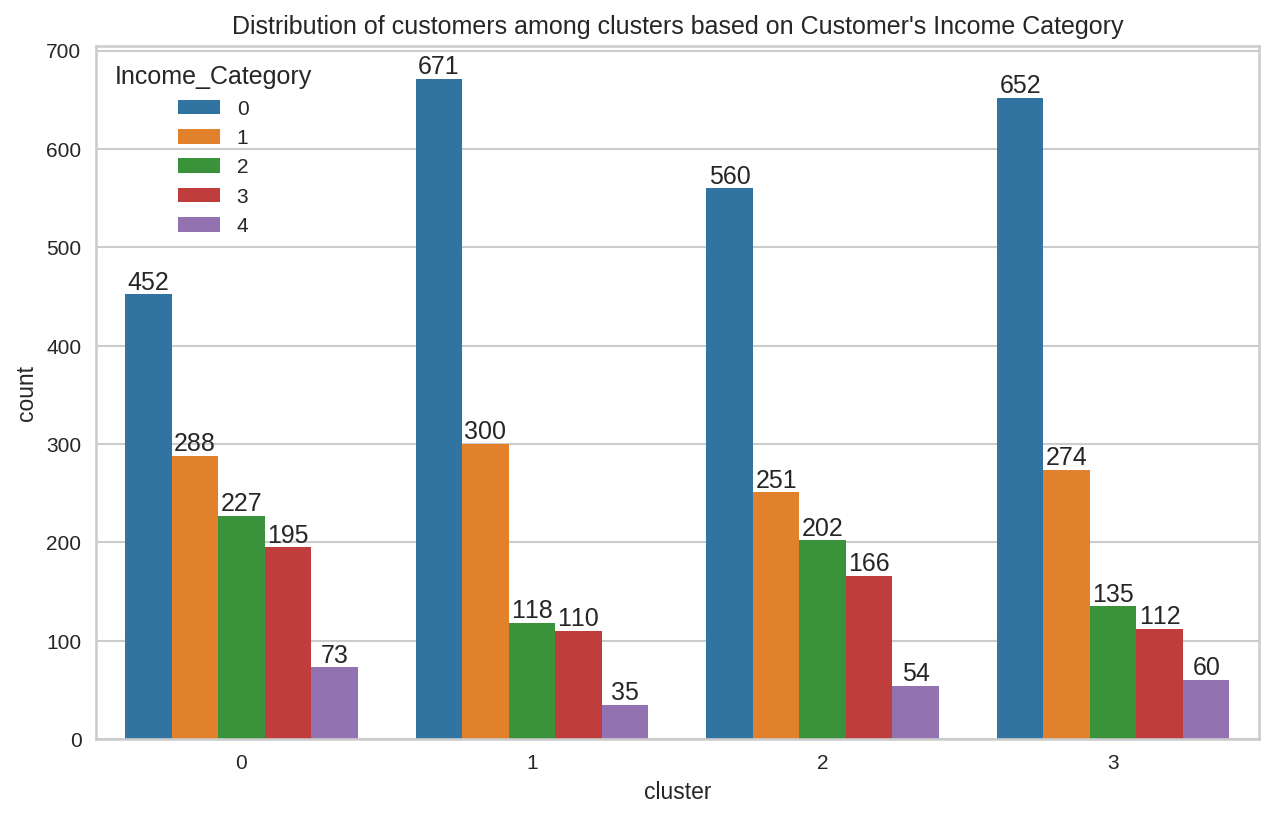

In [ ]:
plt.figure(figsize=(10,6),dpi= 150)
palette = [cluster_colors[int(cluster)] for cluster in sorted(visualDHC['cluster'].unique())]
a = sns.countplot(data=visualDHC.sort_values(by='cluster'),x='cluster',hue='Income_Category',palette='tab10')
for i in a.containers: a.bar_label(i,)
plt.title ("Distribution of customers among clusters based on Customer's Income Category");

- **Nhóm thu nhập dưới 40K** (Màu xanh dương): Chiếm ưu thế trong tất cả các cụm, cho thấy rằng nhóm thu nhập này có đại diện cao nhất trong tập dữ liệu.
- **Nhóm thu nhập 40K-60K** (Màu cam): Là nhóm có đại diện nhiều thứ hai trong mỗi cụm.
- **Nhóm thu nhập 60K-80K** (Màu xanh lá), **80K-120K** (Màu đỏ), và **trên 120K** (Màu tím): Có số lượng khách hàng tương đối ít hơn trong tất cả các cụm, với nhóm thu nhập trên 120K có đại diện ít nhất.
- **Phân cụm**: Không phân tách rõ ràng theo nhóm thu nhập, cho thấy rằng khách hàng từ các nhóm thu nhập thấp được phân bố đều trong tất cả các cụm.


In [ ]:
fig = px.scatter(visualDHC, x="Total_Trans_Ct", y="Total_Trans_Amt",
                color='cluster', color_discrete_sequence=colors, opacity=0.8, symbol='cluster')
fig.update_yaxes(title_text="Total Transaction Amount")
fig.update_xaxes(title_text="Total Transaction Count")
fig.update_traces(showlegend=True)
fig.update_layout(title="Cluster's Profile Based On Total Transaction Count and Total Transaction Amoun")
fig.show()

In [ ]:
fig = px.box(visualDHC, x="cluster", y="Total_Trans_Amt",
             color='cluster', color_discrete_sequence=colors, points='all')
fig.update_yaxes(title_text="Total Transaction Amount")
fig.update_xaxes(title_text="Clusters")
fig.show()

In [ ]:
fig = px.box(visualDHC, x="cluster", y="Credit_Limit", color='cluster', color_discrete_sequence=colors, points='all')
fig.update_yaxes(title_text="Credit Limit")
fig.update_xaxes(title_text="Clusters")
fig.show()

<Figure size 800x550 with 0 Axes>

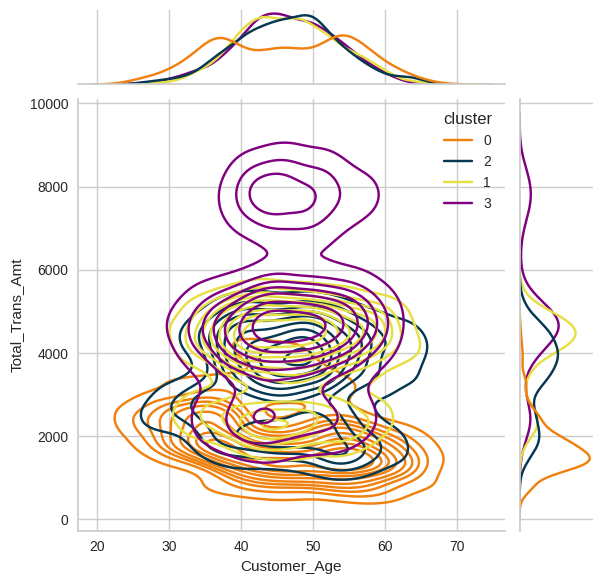

<Figure size 800x550 with 0 Axes>

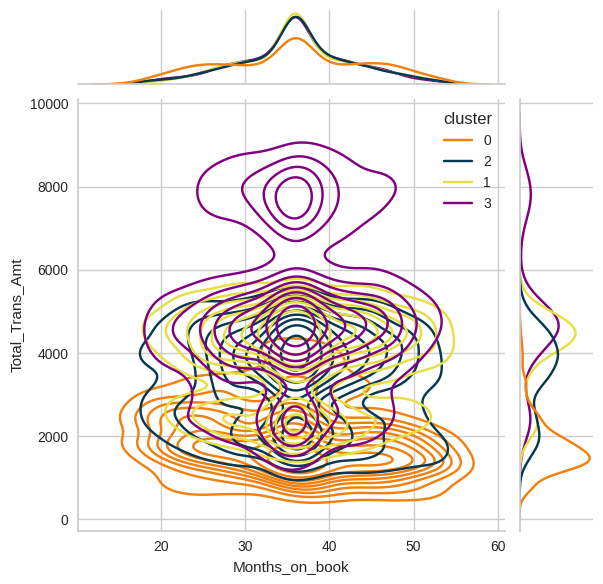

<Figure size 800x550 with 0 Axes>

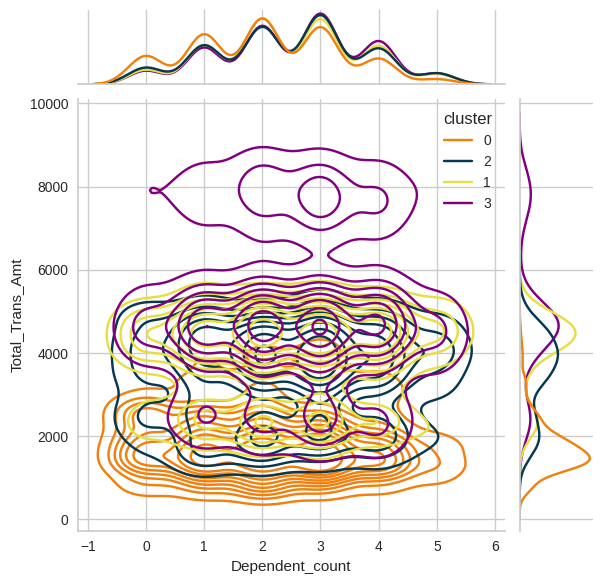

<Figure size 800x550 with 0 Axes>

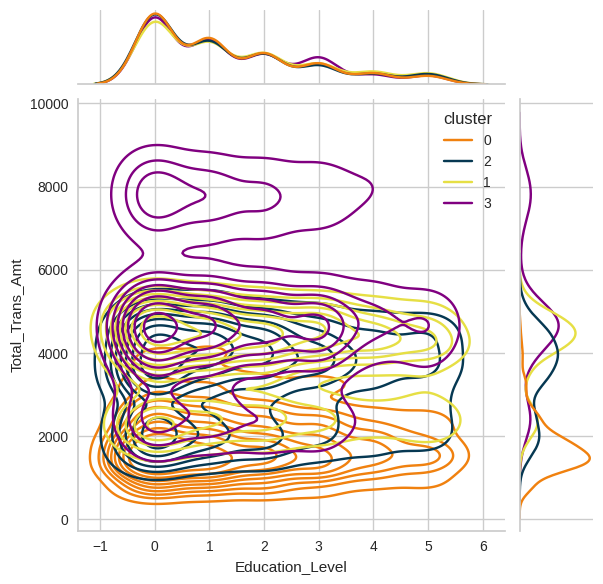

<Figure size 800x550 with 0 Axes>

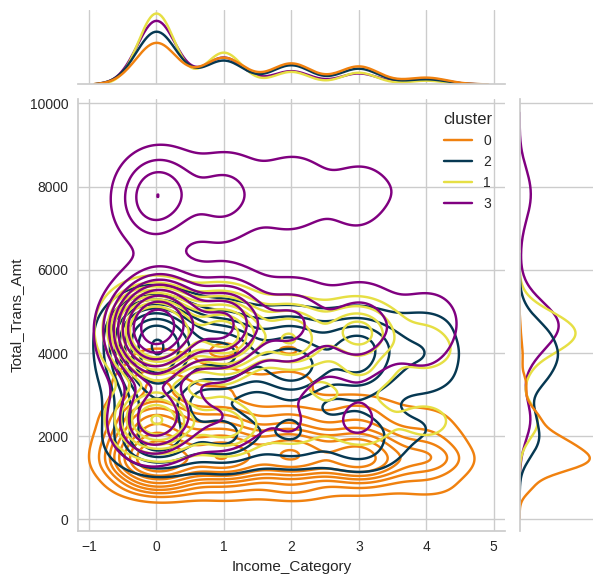

<Figure size 800x550 with 0 Axes>

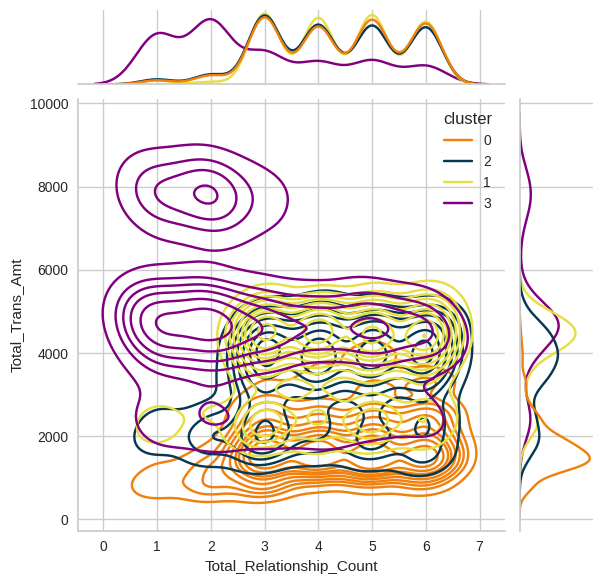

<Figure size 800x550 with 0 Axes>

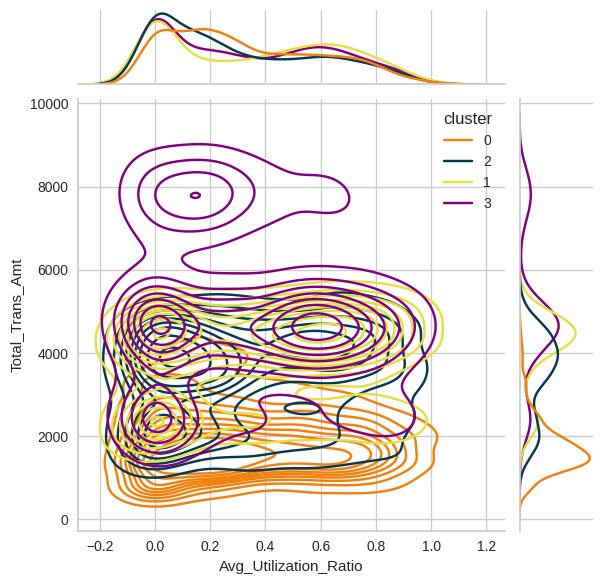

<Figure size 800x550 with 0 Axes>

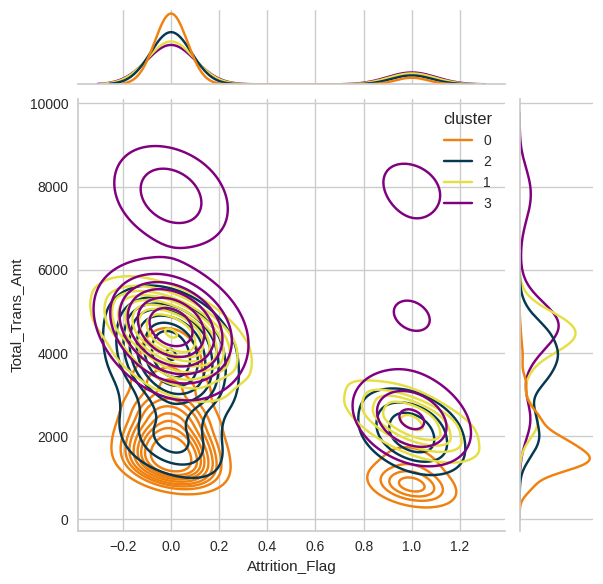

In [ ]:
category = ["Customer_Age", "Months_on_book", "Dependent_count", "Education_Level", "Income_Category", "Total_Relationship_Count", "Avg_Utilization_Ratio", 'Attrition_Flag']

for i in category:
    plt.figure()
    sns.jointplot(x=visualDHC[i], y=visualDHC["Total_Trans_Amt"], hue =visualDHC["cluster"], kind="kde", palette=colors)
    plt.show()

# **3. Kết luận**
- **Cluster 0**:
  - Khách hàng trong nhóm này đa số là những người có thu nhập dưới 40K, số lượng khách hàng ở các mức thu nhập khác cũng cao hơn các nhóm khác.
  - Số lượng khách hàng rời bỏ trong nhóm này thấp
  - Số lượng giao dịch cũng thấp nhất trong 4 cụm, hạn mức giao dịch ở mức phổ thông và ổn định. Tổng lượng giao dịch của khách hàng trong nhóm còn thấp mặc dù hạn mức tín dụng có những khách cao.
  - Đa số độ tuổi của nhóm này đa dạng tuổi hơn các nhóm còn lại
- **Cluster 1**:
  - Số lượng khách hàng có thu thập thấp hơn các nhóm.
  - Tổng lượng giao dịch trung bình ở mức giữa, chứng tỏ các khách hàng này trong giai đoạn chi tiêu nhiều cho cuộc sống.
  - Độ tuổi của nhóm này ít đa dạng, phần lớn từ 42-51
- **Cluster 2**:
  - Chủ yếu là khách hàng mức thu nhập trung bình
  - Tỉ lệ chưa rời bỏ là cao
  - Độ tuổi chính của nhóm này cao hơn các nhóm khác
  - Mức chi tiêu rất đa dạng
- **Cluster 3**:
  - Nhóm này có nhiều người thu nhập ở mức thấp và cũng nhiều người thu nhập mức cao so với các nhóm còn lại. Nhóm này có thu nhập cao nhất.
  - Mức chi tiêu của khách hàng trong nhóm này cao, có thể lên tới trên 8K
  - Nhưng số khách hàng đã rời bỏ của nhóm này cũng là cao nhất

